In [8]:
# Load the Drive helper and mount
#from google.colab import drive

# for tensorboard log folder name
from time import time

# working with, mainly resizing, images
import cv2                 

# dealing with arrays
import numpy as np         

# dealing with directories
import os                  

# mixing up or currently ordered data that might lead our network astray in training.
from random import shuffle 

# a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion
from tqdm import tqdm      

# neural networks
import tensorflow as tf

# use PlaidML as backend for hardware acceleration
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

# This will prompt for authorization.
#drive.mount('/content/drive')

TRAIN = False
FOLDER_PREFIX = '/Users/harri/Programming/ml/dogs_vs_cats'
TRAIN_DIR = '{}{}'.format(FOLDER_PREFIX, '/train')
print('training directory: {}'.format(TRAIN_DIR))
TEST_DIR = '{}{}'.format(FOLDER_PREFIX, '/test')
print('testing directory: {}'.format(TEST_DIR))
IMG_SIZE = 64
BATCH_SIZE = 32
#LR = 1e-3

# just so we remember which saved model is which, sizes must match
MODEL_NAME = '{}{}'.format(FOLDER_PREFIX, '/dogs-vs-cats-{}.model'.format('2conv-basic1'))

def label_img(imgname):
    file_extension = imgname.split('.')[-1]
    if file_extension != 'jpg': return 2
    word_label = imgname.split('.')[-3]
    if word_label == 'cat': return 0
    elif word_label == 'dog': return 1

    
def create_train_data():
    training_data = []
    img = []
    for imgname in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(imgname)
        if label == 2:
            continue
        try:
            path = os.path.join(TRAIN_DIR,imgname)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            training_data.append([np.array(img),np.array(label)])
        except Exception as e:
            print("error with image: '{}', exception: {}".format(imgname, str(e)))
    shuffle(training_data)
    np.save('{}{}'.format(FOLDER_PREFIX, '/train_data_64_small.npy'), training_data)
    return training_data


def create_test_data():
    testing_data = []
    for imgname in tqdm(os.listdir(TEST_DIR)):
        try:
            path = os.path.join(TEST_DIR,imgname)
            img_num = imgname.split('.')[0]
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            testing_data.append([np.array(img), img_num])
        except Exception as e:
            print("error with image: '{}', exception: {}".format(imgname, str(e)))
    shuffle(testing_data)
    np.save('{}{}'.format(FOLDER_PREFIX, '/test_data_64_small.npy'), testing_data)
    return testing_data


# Check if training data file alrady exists
train_data_exists = os.path.isfile('{}{}'.format(FOLDER_PREFIX, '/train_data_64_small.npy'))
if train_data_exists:
    # We have already created the dataset
    train_data = np.load('{}{}'.format(FOLDER_PREFIX, '/train_data_64_small.npy'))
else:
    # Create the dataset
    train_data = create_train_data()

# Check if testing data file alrady exists
test_data_exists = os.path.isfile('{}{}'.format(FOLDER_PREFIX, '/test_data_64_small.npy'))
if test_data_exists:
    # We have already created the dataset
    test_data = np.load('{}{}'.format(FOLDER_PREFIX, '/test_data_64_small.npy'))
else:
    # Create the dataset
    test_data = create_test_data()

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation=tf.nn.relu, input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(512, (5, 5), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2,  activation=tf.nn.softmax)
])
    
model.compile(optimizer='adam', 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

if os.path.exists(MODEL_NAME):
    model.load_weights(MODEL_NAME)
    print('model loaded!')


shuffle(train_data)
train = train_data[:2000]
test = train_data[2000:2050]

print(len(train))
print(len(test))

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = np.array([i[1] for i in train])

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = np.array([i[1] for i in test])


if TRAIN == True:
    
    #tensorboard = tf.keras.callbacks.TensorBoard(log_dir='{}{}'.format(FOLDER_PREFIX, '/logs/{}'.format(time())))

    model.fit(X,
              Y,
              epochs=4, 
              steps_per_epoch=500,
              validation_data=(test_x,test_y),
              validation_steps=50)
              #validation_split=0.02,
              #validation_steps=25,
              #steps_per_epoch=num_train_examples,
              #validation_data=(test_x, test_y),
              #callbacks=[tensorboard])


    model.save(MODEL_NAME)
    


training directory: /Users/harri/Programming/ml/dogs_vs_cats/train
testing directory: /Users/harri/Programming/ml/dogs_vs_cats/test
model loaded!
2000
50


In [10]:
test = train_data[12345:12395]
test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = np.array([i[1] for i in test])

test_loss, test_accuracy = model.evaluate(test_x,test_y, steps=50)
print('Accuracy on test dataset:', test_accuracy)


50/50 [==============================] - 7s 137ms/step - loss: 3.4401 - acc: 0.7400
Accuracy on test dataset: 0.74


(64, 64, 1)


TypeError: Invalid dimensions for image data

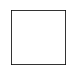

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(1,1))
#i = 0
image = test_x[0]
print(image.shape)
#for (image) in test_x.take(25):
    #image = image.numpy().reshape((28,28))
plt.subplot(1,1,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(image, cmap=plt.cm.binary)
#plt.xlabel(class_names[label])
#i += 1
plt.show()
